In [1]:
#Imports 
import sys
import os
import json
import socket
from datetime import datetime

from transporter import *

from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, Sampler

# Check if CUDA is available, otherwise use CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print("Current device is set to: ", device)

Current device is set to:  cuda


In [2]:
# Generate Data from Atari Pong using DeepMind Atari Wrapper
# Atari Environment is made using OpenAI Gym + Stable Baselines3
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

# In case you get a .dll missing error (happens on Windows), replace the atari-py 
#that comes with stable_baselines with the one found at https://github.com/Kojoley/atari-py

import stable_baselines3
from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3 import A2C

env = make_atari_env('PongNoFrameskip-v4', n_envs=1, seed=4242)
env._max_episode_steps = 100
data_dir = 'C:/code/heart-tracking/data/processed/atari/pong'

num_trajectories = 10
num_steps = 100
obs = env.reset()
print("Data will be saved to {}".format(data_dir))

with tqdm(total=num_trajectories * num_steps) as pbar:
    for n in range(num_trajectories):
        os.makedirs('{}/{}'.format(data_dir, n), exist_ok=True)
        obs = env.reset()
        t = 0
        img = env.render(mode='rgb_array')
        Image.fromarray(img).save('{}/{}/{}.png'.format(data_dir, n, t))
        images = []
        while True:
            action = [env.action_space.sample()]
            obs, r, done, _ = env.step(action)
            img = env.render(mode='rgb_array')
            Image.fromarray(img).save('{}/{}/{}.png'.format(data_dir, n, t))
            images.append(obs)
            t += 1
            if done:
                break
        pbar.update(num_steps)
    with open('{}/metadata.json'.format(data_dir), 'w') as out:
        json.dump({
            'num_trajectories': num_trajectories,
            'num_timesteps': num_steps
        }, out)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Data will be saved to C:/code/heart-tracking/data/processed/atari/pong


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 69.68it/s]


In [7]:
# Load the Data we created into PyTorch Dataset Loader
# https://pytorch.org/docs/stable/data.html#dataset-types

class AtariDataset(Dataset):
    _meta_data_file = 'metadata.json'
    def __init__(self, root, transform=None):
        self._root = root
        self._transform = transform
        with open('{}/{}'.format(root, self._meta_data_file), 'rt') as inp:
            self._metadata = json.load(inp)

    @property
    def num_trajectories(self):
        return self._metadata['num_trajectories']

    @property
    def num_timesteps(self):
        return self._metadata['num_timesteps']

    def __len__(self):
        raise NotImplementedError

    def get_image(self, n, t):
        im = np.array(Image.open('{}/{}/{}.png'.format(self._root, n, t)))
        return im

    def __getitem__(self, idx):
        n, t, tp1 = idx
        imt = np.array(Image.open('{}/{}/{}.png'.format(self._root, n, t)))
        imtp1 = np.array(Image.open('{}/{}/{}.png'.format(self._root, n, tp1)))
        if self._transform is not None:
            imt = self._transform(imt)
            imtp1 = self._transform(imtp1)

        return imt, imtp1
    
    def get_trajectory(self, idx):
        images = [np.array(Image.open('{}/{}/{}.png'.format(self._root, idx, t))) for t in range(self.num_timesteps)]
        return [self._transform(im) for im in images]

class AtariSampler(Sampler):
    def __init__(self, dataset):
        self._dataset = dataset

    def __iter__(self):
        while True:
            n = np.random.randint(self._dataset.num_trajectories)
            num_images = self._dataset.num_timesteps
            t_ind = np.random.randint(0, num_images - 20)
            tp1_ind = t_ind + np.random.randint(20)
            yield n, t_ind, tp1_ind

    def __len__(self):
        raise NotImplementedError

transformer = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.ToTensor()])

dataset = AtariDataset(data_dir, transform=transformer)
sampler = AtariSampler(dataset)
loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=sampler, pin_memory=True, num_workers=0)

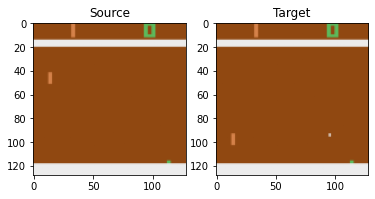

In [8]:
# Display data pair
image, target = next(iter(loader))

image = np.transpose(image[0].numpy(), (1, 2, 0))
target = np.transpose(target[0].numpy(), (1, 2, 0))

fig = plt.figure()
ax = plt.subplot(1, 2, 1)
ax.set_title("Source")
plt.imshow(image)

ax = plt.subplot(1, 2, 2)
ax.set_title("Target")
plt.imshow(target)

In [9]:
sys.path.append('../src/transporter/model/')

IMAGE_CHANNELS = 3
K = 4

# Build Transporter Model architecture
feature_encoder = FeatureEncoder(IMAGE_CHANNELS)
pose_regressor = PoseRegressor(IMAGE_CHANNELS, K)
refine_net = RefineNet(IMAGE_CHANNELS)

transporter_model = Transporter(feature_encoder, pose_regressor, refine_net)
transporter_model.to(device=device)

Transporter(
  (feature_encoder): FeatureEncoder(
    (net): Sequential(
      (0): Block(
        (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Block(
        (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Block(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (3): Block(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (4): Block(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (bn): Batch

In [13]:
# Train the network

optimizer = torch.optim.Adam(transporter_model.parameters(), 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    int(1e5),
    gamma=0.95)

# Create a log directory
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
log_dir = os.path.join('runs', current_time + '_' + socket.gethostname())

os.makedirs(log_dir, exist_ok=True)
print('Logs are written to {}'.format(log_dir))

summary_writer = SummaryWriter(log_dir)


for i, (source, target) in enumerate(loader):
    transporter_model.train()
    source = source.to(device)
    target = target.to(device)
    
    optimizer.zero_grad()
    reconstruction = transporter_model(source, target)
    loss = torch.nn.functional.mse_loss(reconstruction, target)
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if i % 100 == 0:
        print('Itr ', i, 'Loss ', loss)
        torch.save(transporter_model.state_dict(), os.path.join(log_dir, 'transporter_model.pth'))
        summary_writer.add_scalar(
            'reconstruction_loss', loss, global_step=i)
        reconst_grid = torchvision.utils.make_grid(reconstruction)
        source_grid = torchvision.utils.make_grid(source)
        target_grid = torchvision.utils.make_grid(target)
        summary_writer.add_image('source', source_grid, global_step=i)
        summary_writer.add_image('target', target_grid, global_step=i)
        summary_writer.add_image('reconst_target', reconst_grid, global_step=i)
    
    if i > int(1e6):
        break
    summary_writer.close()

Logs are written to runs\Nov30_15-45-55_DESKTOP-DG3L4M0
Itr  0 Loss  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  100 Loss  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  200 Loss  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  300 Loss  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  400 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  500 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  600 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  700 Loss  tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  800 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  900 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  1000 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  1100 Loss  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  1200 Loss  tensor(0.0003, device='cuda:0', grad_fn=

Itr  10900 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11000 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11100 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11200 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11300 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11400 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11500 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11600 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11700 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11800 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  11900 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  12000 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  12100 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  12200 L

Itr  21700 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  21800 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  21900 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22000 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22100 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22200 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22300 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22400 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22500 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22600 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22700 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22800 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  22900 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  23000 L

Itr  32500 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  32600 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  32700 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  32800 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  32900 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33000 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33100 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33200 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33300 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33400 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33500 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33600 Loss  tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33700 Loss  tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  33800 L

Itr  43100 Loss  tensor(6.1383e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43200 Loss  tensor(6.8924e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43300 Loss  tensor(4.8881e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43400 Loss  tensor(6.4438e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43500 Loss  tensor(5.9631e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43600 Loss  tensor(5.2299e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43700 Loss  tensor(5.5756e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43800 Loss  tensor(4.4512e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  43900 Loss  tensor(6.3240e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  44000 Loss  tensor(5.1056e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  44100 Loss  tensor(5.8382e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  44200 Loss  tensor(3.6411e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  44300 Loss  tensor(6.7356e-05, devi

Itr  53400 Loss  tensor(3.0160e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  53500 Loss  tensor(4.8233e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  53600 Loss  tensor(5.3472e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  53700 Loss  tensor(3.9016e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  53800 Loss  tensor(6.4515e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  53900 Loss  tensor(5.3882e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54000 Loss  tensor(4.8757e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54100 Loss  tensor(4.7276e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54200 Loss  tensor(2.8526e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54300 Loss  tensor(6.6997e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54400 Loss  tensor(4.6558e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54500 Loss  tensor(6.2987e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  54600 Loss  tensor(6.3909e-05, devi

Itr  63700 Loss  tensor(4.3431e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  63800 Loss  tensor(7.7143e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  63900 Loss  tensor(5.2925e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64000 Loss  tensor(6.4760e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64100 Loss  tensor(4.7035e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64200 Loss  tensor(5.8152e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64300 Loss  tensor(6.4664e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64400 Loss  tensor(6.8914e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64500 Loss  tensor(4.4047e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64600 Loss  tensor(4.8626e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64700 Loss  tensor(5.4079e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64800 Loss  tensor(6.6953e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  64900 Loss  tensor(6.7137e-05, devi

Itr  74000 Loss  tensor(1.8204e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74100 Loss  tensor(2.5820e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74200 Loss  tensor(7.2633e-06, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74300 Loss  tensor(1.2546e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74400 Loss  tensor(3.3993e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74500 Loss  tensor(3.1793e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74600 Loss  tensor(3.2315e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74700 Loss  tensor(2.4409e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74800 Loss  tensor(1.8194e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  74900 Loss  tensor(3.3737e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  75000 Loss  tensor(4.9480e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  75100 Loss  tensor(1.8088e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  75200 Loss  tensor(2.6769e-05, devi

Itr  84300 Loss  tensor(1.1775e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84400 Loss  tensor(4.5673e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84500 Loss  tensor(2.8708e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84600 Loss  tensor(1.6439e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84700 Loss  tensor(1.8693e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84800 Loss  tensor(1.1190e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  84900 Loss  tensor(2.6110e-05, device='cuda:0', grad_fn=<MseLossBackward>)
Itr  85000 Loss  tensor(1.0451e-05, device='cuda:0', grad_fn=<MseLossBackward>)


KeyboardInterrupt: 

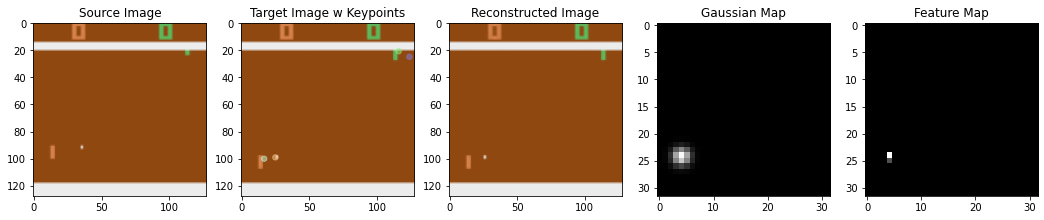

In [37]:
from matplotlib.patches import Circle

def get_random_color(pastel_factor=0.5):
    return [(x + pastel_factor) / (1.0 + pastel_factor)
            for x in [np.random.uniform(0, 1.0) for i in [1, 2, 3]]]


def color_distance(c1, c2):
    return sum([abs(x[0] - x[1]) for x in zip(c1, c2)])


def generate_new_color(existing_colors, pastel_factor=0.5):
    max_distance = None
    best_color = None
    for i in range(0, 100):
        color = get_random_color(pastel_factor=pastel_factor)
        if not existing_colors:
            return color
        best_distance = min([color_distance(color, c) for c in existing_colors])
        if not max_distance or best_distance > max_distance:
            max_distance = best_distance
            best_color = color
    return best_color


def get_n_colors(n, pastel_factor=0.9):
    colors = []
    for i in range(n):
        colors.append(generate_new_color(colors, pastel_factor=0.9))
    return colors

with torch.no_grad():
    transporter_model.eval()
    
    image, target = next(iter(loader))
        
    image = image.to(device=device)
    target = target.to(device=device)
    
    keypoints = transporter_model.point_net(target)
    reconstruction = transporter_model(image, target)
    
    fig, ax = plt.subplots(1, 5, figsize=(18, 5))
    idx = 6
    k_idx = 2
    std = 0.1

    feature_maps = spatial_softmax(keypoints)
    gmap = gaussian_map(feature_maps, std)[idx, k_idx]

    ax[0].set_title('Source Image')    
    ax[0].imshow(np.transpose(image[idx].cpu().numpy(), (1, 2, 0)), cmap='gray')
    
    ax[1].set_title('Target Image w Keypoints') 
    ax[1].imshow(np.transpose(target[idx].cpu().numpy(), (1, 2, 0)))
    
    ax[2].set_title('Reconstructed Image')
    ax[2].imshow(np.transpose(reconstruction[idx].cpu().numpy(), (1, 2, 0)))
    
    ax[3].set_title('Gaussian Map')
    ax[3].imshow(gmap.cpu().detach().numpy(), cmap='gray', vmin=0, vmax=1)
    
    ax[4].set_title('Feature Map')
    ax[4].imshow(feature_maps[idx, k_idx].cpu().numpy(), cmap='gray')

    locs = compute_keypoint_location_mean(spatial_softmax(transporter_model.point_net(target)))[idx]

    colors = get_n_colors(len(locs))
    for i, l in enumerate((locs + 1) / 2 * 128):
        ax[1].add_patch(Circle((l[1].item(), l[0].item()), 2, 
                               color=colors[i], alpha=0.5))